# Interpreting Machine Learning using Shap Value 

Anderson Nelson  <br>
Date: 12/01/2019 <br>

### Introduction

Traditionally there’s been a tradeoff between interpretability and performance. Classical machine learning methods such as linear and logistic regression make it easy to understand why a certain value was classified, however, assumptions of regression models limit the performance potential of these linear models. To improve accuracy, complex models may use hundreds, in some cases, thousands, trees and then combine their results . The financial industry is heavily regulated, and practitioners are obligated to explain why their model made a prediction, and that threshold has limited the types of models that can be implemented. This week I’m going to focus on understanding what’s driving each prediction for the Machine learning algorithms using SHAP (Shapley Additive Explanations). 

SHAP was introduced at 31st Conference on Neural Information Processing Systems (NIPS 2017) and is a technique used in game theory to determine how much each player in a collaborative game has contributed to its success. In this models, each SHAP value measures how much each feature in our model contributes, either positively or negatively, to a customer’s default risk score.

SHAP value is useful in understanding the variables that impact the model’s decision; however, model interpretability can suffer if the features are correlated, and the model doesn’t provide the ability to estimate the impact of change in variables.  In this section, I will interpret the SHAP values for a  Random Forest,and AdaBoost


In [34]:
import numpy as np
import shap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import Lasso

from tabulate import tabulate

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [35]:
def correlation_threshold(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset    

def normalized(data): 
    """Calculates the z score between two data sets"""
    mean = data.mean()
    sd = data.std()
    score = (data - mean) / sd
    return score 

def column_scaler(data, column_skip): 
    """ 
    Scales each column in the dataset 
    """
    new_data = pd.DataFrame()
    
    for value in data.columns: 
        if value in column_skip: 
            new_data[value] = data[value]
        else: 
            column_data = data[value]
            new_data[value] = normalized(column_data)
    return new_data

### Data Preparation

In [36]:
# read data 
data = pd.read_csv('../Data/XYZloan_default_selected_vars.csv')
# drop neccessary columns 
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [37]:
data['MB005']

0         7.0
1         NaN
2         8.0
3        10.0
4         NaN
         ... 
79995    11.0
79996     6.0
79997    12.0
79998     6.0
79999     7.0
Name: MB005, Length: 80000, dtype: float64

The first thing i wanted to do is check whether the data contains any duplicate id.

In [38]:
# are there any duplicated id 
sum(data.id.duplicated())

0

The first step to an analysis is to understand the data. Lets start with understanding how missing values.

In [39]:
f'{round(sum(data.isna().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is missing'

'9.0% of the data is missing'

In [40]:
f'{round(sum(data.isnull().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is null'

'9.0% of the data is null'

The number of missing values represents a small percentage of the dataset. However, those values shouldn’t be ignored. There are a number of different strategies to deal with missing values.

    1. Imputation
    2. Deletion

Exploring the colums with missing data will allow us to determine the best strategy to solve the missing data problem.

In [41]:
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)

The graph shows us that there are a few collumn where more than 99% of the data is missing or null

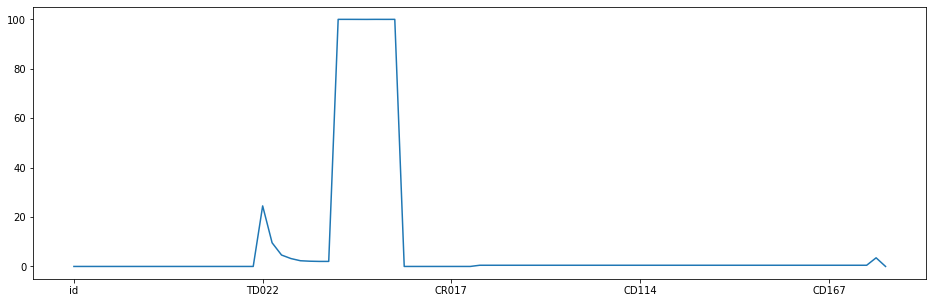

In [42]:
fig = plt.figure(figsize=(16,5))
col_missing.plot()
plt.show()

In [43]:
col_missing[col_missing > 99]

TD044    100.00
TD048    100.00
TD051     99.99
TD054     99.98
TD055    100.00
TD061     99.99
TD062    100.00
dtype: float64

We will remove those columns since 

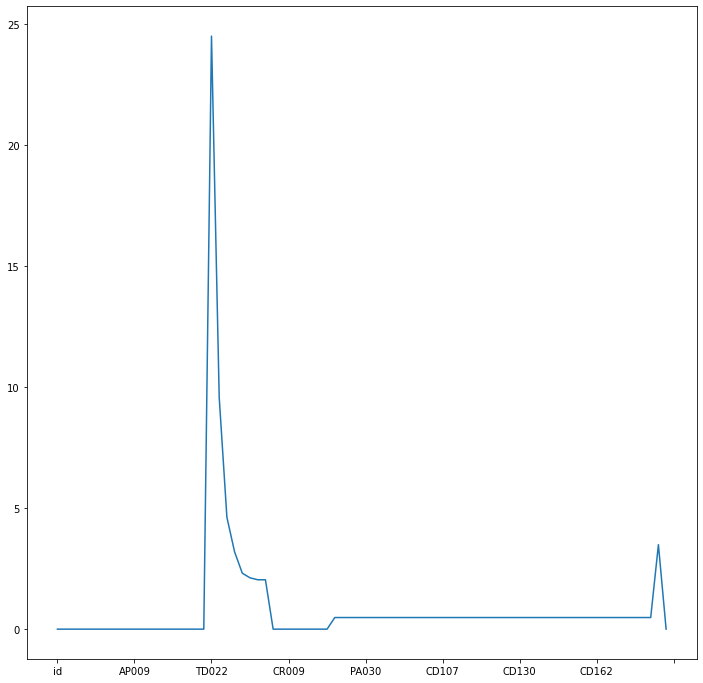

In [44]:
data = data.drop(columns=col_missing[col_missing > 99].index)
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)
fig = plt.figure(figsize=(12,12))
col_missing.plot()
plt.show()

A few users represent the missing values in the data; after further analysis, it seems that missing patterns exist from a distinct group of users. The columns that have missing values also follow a pattern; they are all related to the phone. There are several reasons why that column could be missing: but the most likely reason is that those people don’t have a phone number, or it was never provided to the company.

The best option is to either remove them from the data or impute with 0. If we exclude from the data, a small but essential segment of our population could be misrepresented; on the contrary, if we include it could potentially skew the analysis since we assumed the missing values.

However, inputting the values with 0 makes the most sense for this data since, given that the users do not have a phone, the bank would be unable to call, leave voicemails and converse with the client, which is fair.

In [45]:
col_missing.sort_values(ascending=False)

TD022    24.50
TD023     9.58
TD024     4.62
MB005     3.49
TD025     3.19
         ...  
CR015     0.00
CR017     0.00
CR018     0.00
CR019     0.00
id        0.00
Length: 80, dtype: float64

In [46]:
data = data.fillna(0)

The MB007 column contains many categorical values. I discovered that the top 9 values contribute to over 90% of the distribution. I gave the other categories the value of 'Other'. 

In [47]:
MB007_value_count = pd.DataFrame(data.MB007.value_counts())
MB007_value_count['cum_sum'] = MB007_value_count.cumsum()
MB007_value_count['%'] = MB007_value_count['cum_sum'] / 80000
MB007_value_count = MB007_value_count.drop(index='Noinfo')

In [48]:
data['MB007'] = data['MB007'].apply(lambda i: i if i in MB007_value_count[1:10].index else 'Other')

In [49]:
MB007_columns = list(pd.get_dummies(data.MB007).columns)
AP006_columns = list(pd.get_dummies(data.AP006).columns)
columns_skip = MB007_columns + AP006_columns

Since the values in column MBOO7 and AP006 are not ordinal, to prevent the model from assigning a higher value to the categorical data. I will One hot encode the variables 

In [50]:
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.MB007)], axis=1)
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.AP006)], axis=1)
data = data.drop(columns=['MB007','AP006','AP004'])

The date field can be misleading, it can become a unique identifier for each record. I'm going to split into date and time. 

In [51]:
date_time = data['AP005'].str.split(' ',1,expand=True)
date_time.columns = ['Date','Time']
columns_skip = columns_skip + list(date_time.columns)

After searching throughout the entire model for abnormalities, I found that the are numerous -99 value, which is another form of Null recorded. A small number of users have a considerable proportion of 99 values in their records. Those users can skew the model results, and I remove them.

In [52]:
# how many -99 values per user id 
user_list_99 = []
for row in range(0, len(data)):
    row_data = data.iloc[row]
    user_list_99.append(list(row_data).count(-99))

In [53]:
_99_count= pd.DataFrame({'id': data.iloc[:,0],
             '99_count' : user_list_99})

In [54]:
# how many id have more than 1 -99 values and how many 99 values exsist 
_99_count[_99_count['99_count'] > 0]
_99_count[_99_count['99_count'] > 0]['99_count'].value_counts()

36    1773
42    1534
Name: 99_count, dtype: int64

In [55]:
f'{round((len(_99_count[_99_count["99_count"] > 0]["99_count"]) / len(data)) * 100,2)}% of users have more than 36 values labels as -99 in their respective row'

'4.13% of users have more than 36 values labels as -99 in their respective row'

In [56]:
# remove the ids with -99 values 
_99_count[_99_count['99_count'] > 0]['id'].values
data = data[~data.iloc[:,0].isin(_99_count[_99_count['99_count'] > 0]['id'].values)].reset_index()

Lastly, I found that the date variable had predictive power in my model, However, it doesn't make sense to include in my model. 

In [57]:
# covert AP005 into date and time 
data = data.drop(columns='AP005')

Convert 0 = No and 1 = Yes in the default

In [58]:
# convert the loan_faults into categerical 
# data['loan_default'] = np.where(data['loan_default'] == 0, 'No','Yes')

The data contains several highly multicollinearity features, which negatively impact the prediction and interpretability of linear models.  Multicollinearity increases the variance of the coefficient estimates and makes the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret. Multicollinearity saps the statistical power of the analysis, can cause the coefficients to switch signs, and makes it more difficult to specify the correct model.

To address this, I'm going to remove the columns with more than 0.8 correlation. 

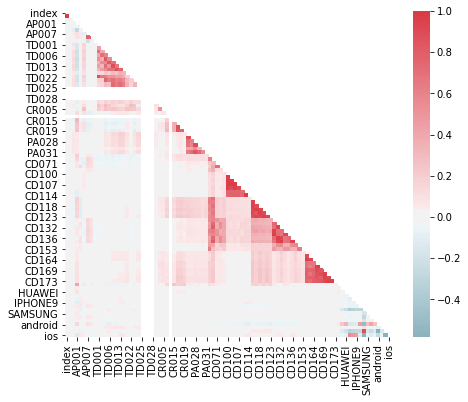

In [59]:
fig = plt.figure(figsize=(8,6))
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and caorrect aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

In [60]:
data = correlation_threshold(data,0.80)
clean_data= data.drop(columns=['index'])

In [61]:
col_des = correlation_threshold(data,0.80).isna().sum()
clean_data = clean_data.drop(columns=col_des[col_des > 0 ].index)

In [62]:
var_dict = pd.read_csv('../Data/Variables_Dictionary_2019.csv')
var_dict = var_dict[var_dict['Var'].isin(clean_data.columns)]

new_dict = dict()
for value in range(0,len(var_dict)-1): 
    new_dict[var_dict.iloc[value,1]] = var_dict.iloc[value,3]

new_column_name = []

for column in clean_data.columns:
    try: 
        new_column_name.append(new_dict[column]) 
    except KeyError:
        new_column_name.append(column)
        
clean_data.columns = new_column_name

In [63]:
target = 'loan_default'
predictors = clean_data.columns[1:]

In [64]:
Y = clean_data[target]
X = clean_data[predictors]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

### Feature Selection
Using the random forest important feauture i found that the top 31 features contirubutes to 90% of prediction value

In [65]:
rf_ft = RandomForestRegressor()
rf_ft.fit(X_train, Y_train)

RandomForestRegressor()

In [66]:
rf_feature_importance = pd.DataFrame({'Name': X_train.columns,
             'Feature Importances': rf_ft.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by = 'Feature Importances',ascending=False).reset_index()
rf_feature_importance = rf_feature_importance.drop(columns='index')

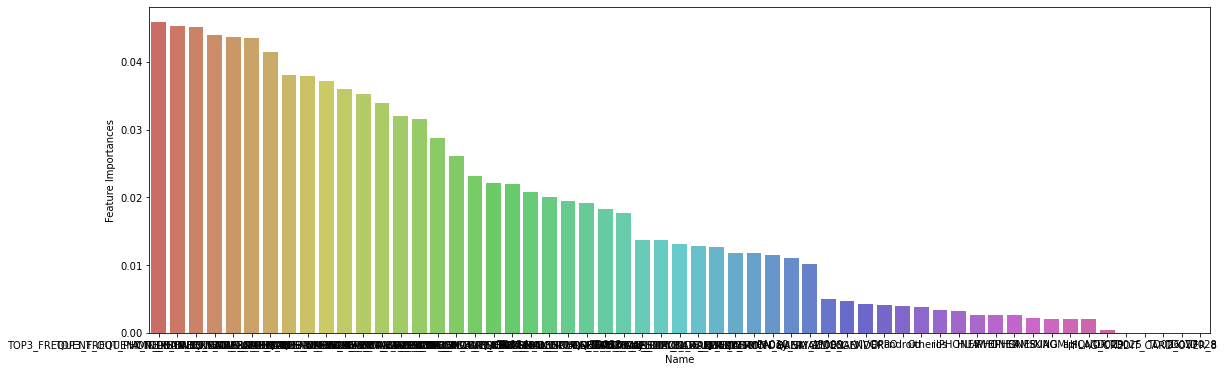

In [67]:
fig = plt.figure(figsize=(19,6))
sns.barplot(x ='Name', y = 'Feature Importances', data=rf_feature_importance, palette = 'hls')

In [68]:
rf_feature_importance['cum_sum'] = rf_feature_importance['Feature Importances'].cumsum()
rf_feature_importance

,Name,Feature Importances,cum_sum
0,TOP3_FREQUENT_OUT_PHONE_NUMBERS_OUT_CALLS_3MON,0.045845,0.045845
1,AMT_LOAN_TOTAL,0.045357,0.091202
2,TOP3_FREQUENT_IN_PHONE_NUMBERS_IN_CALLS_3MON,0.045129,0.136331
3,DISTINCT_CALLS_1MON,0.043911,0.180242
4,IN_CALLS_1MON,0.043686,0.223928
5,SVC_CALL1MON,0.043454,0.267383
6,TOTAL_OUT_CALLS_3MON,0.041439,0.308822
7,TOP3_FREQUENT_OUT_PHONE_NUMBERS_IN_CALLS_2MON,0.038042,0.346864
8,COLLEAGUE_CALLS_3MON,0.037907,0.384771
9,QUERY_6MON_P2P,0.037124,0.421895


In [69]:
clean_data = clean_data.drop(columns=rf_feature_importance[33:]['Name'].values)

In [70]:
target = 'loan_default'
predictors = clean_data.columns[1:]
Y = clean_data[target]
X = clean_data[predictors]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.001)

### Random Forest

In [71]:
shap.initjs()

rf = RandomForestRegressor()
rf.fit(X_train,Y_train)
rf_explainer = shap.KernelExplainer(rf.predict, X_val)

The below shows features each contributing to pushing the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [72]:
rf_shap_values = rf_explainer.shap_values(X_val)

# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[10,:], X_val.iloc[10,:]) 

In [73]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values[6,:], X_val.iloc[10,:]) 

In [74]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[0,:], X_val.iloc[10,:]) 

In [75]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[20,:], X_val.iloc[10,:]) 

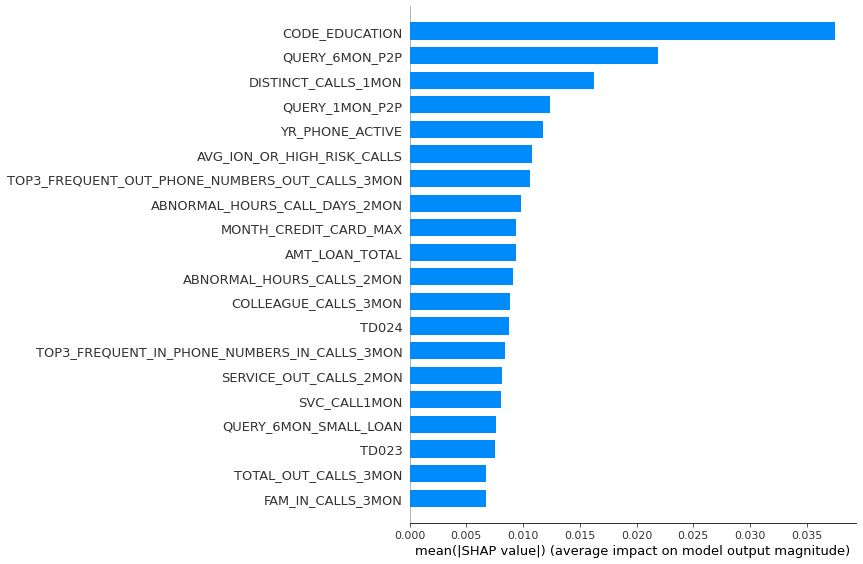

In [76]:
shap.summary_plot(rf_shap_values, X_test, plot_type="bar")

In [77]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_test)

To get an overview of which features are most important for a model plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. 

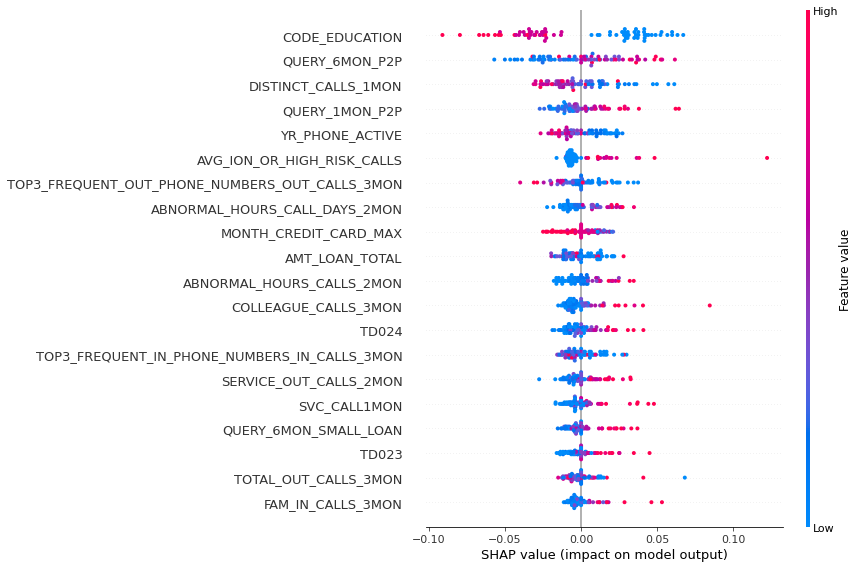

In [78]:
shap.summary_plot(rf_shap_values, X_val)

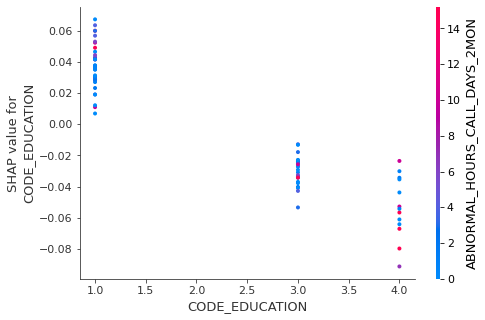

In [79]:
shap.dependence_plot('CODE_EDUCATION',rf_shap_values, X_val)

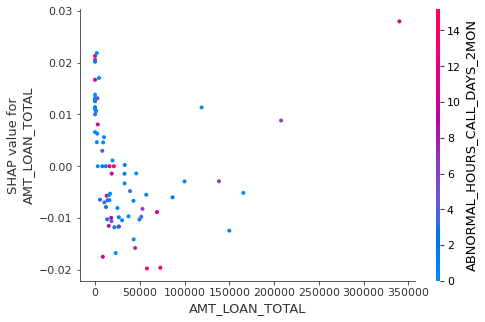

In [80]:
shap.dependence_plot('AMT_LOAN_TOTAL',rf_shap_values, X_val)

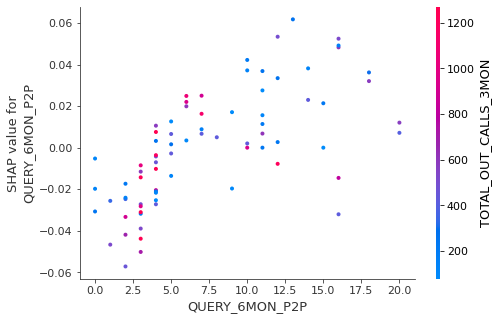

In [81]:
shap.dependence_plot('QUERY_6MON_P2P',rf_shap_values, X_val)

### Ada Boost

In [82]:
n_estimators = 500
ada = ensemble.AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=0)
ada.fit(X_train, Y_train)

AdaBoostClassifier(n_estimators=500, random_state=0)

In [83]:
ada_explainer = shap.KernelExplainer(rf.predict, X_val)
ada_shap_values = ada_explainer.shap_values(X_val)

In [84]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[12,:], X_val.iloc[12,:]) 

In [85]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[21,:], X_val.iloc[21,:]) 

In [86]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[17,:], X_val.iloc[17,:]) 

In [87]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[15,:], X_val.iloc[15,:]) 

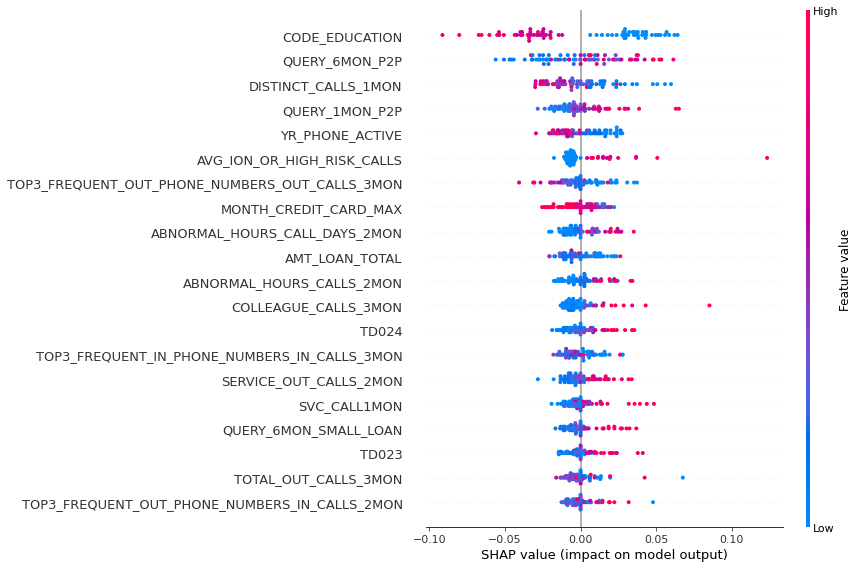

In [88]:
shap.summary_plot(ada_shap_values, X_val)

#### Summary: 
**Education:** The most important variable to predict the default risk of the customer. The model can be interpreted that the higher education, the lower the risk of default.  I’m not assuming that people with higher education care more about their credit, nor that people with lower education are unconscious about paying their bill on time, but rather that education is a sign of affordability, and the ability to earn a higher income. I’m assuming that there’s a confounding variable not present in the model, income, and Education is highly correlated with that variable. The graph shows a clear divide between best in class credit vs. high default risk.  


In [89]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, X_test)

**QUERY_LAST_6MON_P2P:**  I’m assuming that this variable highlight the number of credit request for a new credit request the user performed in the last 6 month. The SHAP value indicates that a high number of request is highly correlated with default. This feature can potentially indicate individuals who are trying to apply for a new card to transfer high balances to the new card. However, that feature alone isn’t predictive of default; Someone could likely be making a huge purchase, like a house and sbe shopping around for the best rate. 

In [90]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, X_test)

In [91]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[6,:], X_val.iloc[6,:]) 

**YEAR_PHONE_ACTIVE:**  The model is indicating that the user who has a phone activated for fewer years are a higher credit risk. Typically in the US, a cell phone is the first credit item someone receives to built credit history. This variable may indicate that people with a short credit history are at a higher risk of default. However, it’s not a strong indicator highlighted by the graph below. 

In a few samples that I’ve evaluated the relative impact on the default is benign compared to other variables. 


In [92]:
yr_age = clean_data[['YR_AGE','YR_PHONE_ACTIVE']]
yr_age.corr()

,YR_AGE,YR_PHONE_ACTIVE
YR_AGE,1.000000,0.412414
YR_PHONE_ACTIVE,0.412414,1.000000


In [93]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, X_test)

Example illustrates the impact of a user with phone active of 3 years. 

In [94]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[58,:], X_val.iloc[58,:]) 

**AVG_ION_OR_HIGH_RISK_CALLS**: 

On average, negative High-Risk Call is benign; however a low call can reduce the risk probability dramatically. There's not enought information given to poperly conduct an anlaysis on what this variable measures.

In [95]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, X_test)

**Monthly Credit Card Max** : SHAP value indicates that users with a high monthly credit card max, have a higher probability of default compared to those with lower max. User with a high credit card utilization is not likely maximizing credit cards by choice. Perhaps the individuals' monthly expenses exceed their income, and they compensate by borrowing against their credit to meet their monthly expenses. 


In [96]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values, X_test)

In [97]:
shap.force_plot(ada_explainer.expected_value, ada_shap_values[12,:], X_val.iloc[12,:]) 

### Conclusion: 

The SHAP value can be useful in demystifying the decision-drivers of complex models such as Random Forest and Boosting models. Based on my observation, the same variable can have a positive impact on one user and a negative impact on another user. Also, the model is capturing relationships not present in the data, such as income and credit history length. 


- Would love to see how income, and credit length history impact the mode. 

### Reference
[Interpreting complex models with SHAP values](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) <br>
[Explain Any Models with the SHAP Values — Use the KernelExplainer](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a) <br>
[Shap](https://github.com/slundberg/shap)<br>
[A Unified Approach to Interpreting Model
Predictions](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)<br>
[Demystifying Black-Box Models with SHAP Value Analysis](https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80)